In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('heart_disease.csv')
df

,Gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,Heart_stroke
0,Male,39,postgraduate,0,0.0,0.0,no,0,0,195.0,106.0,70.0,26.97,80.0,77.0,No
1,Female,46,primaryschool,0,0.0,0.0,no,0,0,250.0,121.0,81.0,28.73,95.0,76.0,No
2,Male,48,uneducated,1,20.0,0.0,no,0,0,245.0,127.5,80.0,25.34,75.0,70.0,No
3,Female,61,graduate,1,30.0,0.0,no,1,0,225.0,150.0,95.0,28.58,65.0,103.0,yes
4,Female,46,graduate,1,23.0,0.0,no,0,0,285.0,130.0,84.0,23.10,85.0,85.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,Male,50,uneducated,1,1.0,0.0,no,1,0,313.0,179.0,92.0,25.97,66.0,86.0,yes
4234,Male,51,graduate,1,43.0,0.0,no,0,0,207.0,126.5,80.0,19.71,65.0,68.0,No
4235,Female,48,primaryschool,1,20.0,NaN,no,0,0,248.0,131.0,72.0,22.00,84.0,86.0,No
4236,Female,44,uneducated,1,15.0,0.0,no,0,0,210.0,126.5,87.0,19.16,86.0,NaN,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           4238 non-null   object 
 1   age              4238 non-null   int64  
 2   education        4133 non-null   object 
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   object 
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  Heart_stroke     4238 non-null   object 
dtypes: float64(8), int64(4), object(4)
memory usage: 529.9+ KB


In [20]:
df.describe()

,age,currentSmoker,cigsPerDay,BPMeds,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
count,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000,3656.000000
mean,49.557440,0.489059,9.022155,0.030361,0.311543,0.027079,236.873085,132.368025,82.912062,25.784185,75.730580,81.856127
std,8.561133,0.499949,11.918869,0.171602,0.463187,0.162335,44.096223,22.092444,11.974825,4.065913,11.982952,23.910128
min,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,83.500000,48.000000,15.540000,44.000000,40.000000
25%,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.080000,68.000000,71.000000
50%,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.380000,75.000000,78.000000
75%,56.000000,1.000000,20.000000,0.000000,1.000000,0.000000,263.250000,144.000000,90.000000,28.040000,82.000000,87.000000
max,70.000000,1.000000,70.000000,1.000000,1.000000,1.000000,600.000000,295.000000,142.500000,56.800000,143.000000,394.000000


In [ ]:
df_fixed = df.describe()
def remove_outliers(df, col):
    """
    Function to remove outliers using the 1.5 × IQR rule for a specific column.
    Outliers are replaced with the median of the column.
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    median = df[col].median()
    df[col] = df[col].mask((df[col] < lower_bound) | (df[col] > upper_bound), median)

# Fix all columns with detected outliers
columns_with_outliers = ['age', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentHyp',
                         'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

for col in columns_with_outliers:
    remove_outliers(df_fixed, col)
df_fixed

In [5]:
df.isna().sum()

Gender               0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
Heart_stroke         0
dtype: int64

In [6]:
df = df.dropna().copy()

In [7]:
df['Heart_stroke'].value_counts()

Heart_stroke
No     3099
yes     557
Name: count, dtype: int64

In [8]:
df

,Gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,Heart_stroke
0,Male,39,postgraduate,0,0.0,0.0,no,0,0,195.0,106.0,70.0,26.97,80.0,77.0,No
1,Female,46,primaryschool,0,0.0,0.0,no,0,0,250.0,121.0,81.0,28.73,95.0,76.0,No
2,Male,48,uneducated,1,20.0,0.0,no,0,0,245.0,127.5,80.0,25.34,75.0,70.0,No
3,Female,61,graduate,1,30.0,0.0,no,1,0,225.0,150.0,95.0,28.58,65.0,103.0,yes
4,Female,46,graduate,1,23.0,0.0,no,0,0,285.0,130.0,84.0,23.10,85.0,85.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4231,Male,58,graduate,0,0.0,0.0,no,1,0,187.0,141.0,81.0,24.96,80.0,81.0,No
4232,Male,68,uneducated,0,0.0,0.0,no,1,0,176.0,168.0,97.0,23.14,60.0,79.0,yes
4233,Male,50,uneducated,1,1.0,0.0,no,1,0,313.0,179.0,92.0,25.97,66.0,86.0,yes
4234,Male,51,graduate,1,43.0,0.0,no,0,0,207.0,126.5,80.0,19.71,65.0,68.0,No


### 1. Исследовательский анализ данных (EDA) и визуализация
На данном этапе важно оценить дисбаланс классов и корреляцию признаков, чтобы избежать мультиколлинеарности.


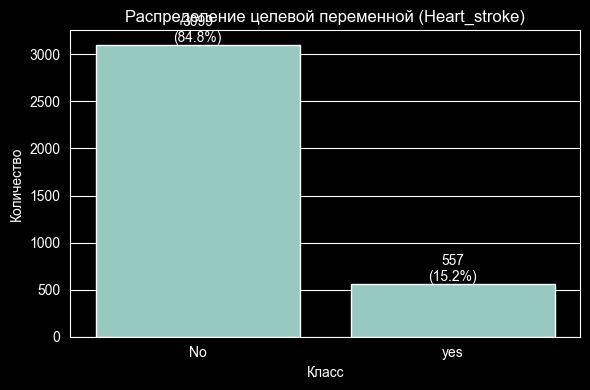

In [9]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(
    x='Heart_stroke',
    data=df
)

total = len(df)
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(
        f'{count}\n({count / total:.1%})',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom'
    )

plt.title('Распределение целевой переменной (Heart_stroke)')
plt.xlabel('Класс')t
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

In [10]:
X = df.drop(columns=['Heart_stroke'])
y = df['Heart_stroke']

cat_features = X.select_dtypes(include='object').columns.tolist()

### 3. Обучение модели и оценка качества


In [11]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(X))

base_params = dict(
    iterations=1500,
    loss_function='Logloss',
    eval_metric='AUC',
    auto_class_weights='Balanced',
    random_seed=42,
    verbose=False
)

for tr, va in skf.split(X, y):
    model = CatBoostClassifier(
        depth=4,
        learning_rate=0.05,
        l2_leaf_reg=10,
        **base_params
    )

    model.fit(
        X.iloc[tr], y.iloc[tr],
        cat_features=cat_features,
        eval_set=(X.iloc[va], y.iloc[va]),
        use_best_model=True
    )

    oof[va] = model.predict_proba(X.iloc[va])[:, 1]

print("CV AUC:", roc_auc_score(y, oof))

CV AUC: 0.7192642787996127


In [12]:
grid = [
    {'depth': 3, 'learning_rate': 0.05, 'l2_leaf_reg': 10},
    {'depth': 4, 'learning_rate': 0.05, 'l2_leaf_reg': 10},
    {'depth': 5, 'learning_rate': 0.05, 'l2_leaf_reg': 10},

    {'depth': 4, 'learning_rate': 0.03, 'l2_leaf_reg': 10},
    {'depth': 4, 'learning_rate': 0.07, 'l2_leaf_reg': 10},

    {'depth': 4, 'learning_rate': 0.05, 'l2_leaf_reg': 5},
    {'depth': 4, 'learning_rate': 0.05, 'l2_leaf_reg': 20},
]

In [13]:
def cv_auc(params):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    oof = np.zeros(len(X))

    for tr, va in skf.split(X, y):
        model = CatBoostClassifier(**base_params, **params)

        model.fit(
            X.iloc[tr], y.iloc[tr],
            cat_features=cat_features,
            eval_set=(X.iloc[va], y.iloc[va]),
            use_best_model=True
        )

        oof[va] = model.predict_proba(X.iloc[va])[:, 1]

    return roc_auc_score(y, oof)

In [14]:
for params in grid:
    auc = cv_auc(params)
    print(f"AUC={auc:.4f} | {params}")

AUC=0.7180 | {'depth': 3, 'learning_rate': 0.05, 'l2_leaf_reg': 10}
AUC=0.7193 | {'depth': 4, 'learning_rate': 0.05, 'l2_leaf_reg': 10}
AUC=0.7144 | {'depth': 5, 'learning_rate': 0.05, 'l2_leaf_reg': 10}
AUC=0.7165 | {'depth': 4, 'learning_rate': 0.03, 'l2_leaf_reg': 10}
AUC=0.7148 | {'depth': 4, 'learning_rate': 0.07, 'l2_leaf_reg': 10}
AUC=0.7148 | {'depth': 4, 'learning_rate': 0.05, 'l2_leaf_reg': 5}
AUC=0.7161 | {'depth': 4, 'learning_rate': 0.05, 'l2_leaf_reg': 20}


In [15]:
# CV AUC: 0.7192642787996127

In [16]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(X))

base_params = dict(
    iterations=1500,
    loss_function='Logloss',
    eval_metric='AUC',
    auto_class_weights='Balanced',
    random_seed=42,
    verbose=False
)

for tr, va in skf.split(X, y):
    model = CatBoostClassifier(
        depth=4,
        learning_rate=0.05,
        l2_leaf_reg=10,
        **base_params
    )

    model.fit(
        X.iloc[tr], y.iloc[tr],
        cat_features=cat_features,
        eval_set=(X.iloc[va], y.iloc[va]),
        use_best_model=True
    )

    oof[va] = model.predict_proba(X.iloc[va])[:, 1]

print("CV AUC:", roc_auc_score(y, oof))

CV AUC: 0.7192642787996127


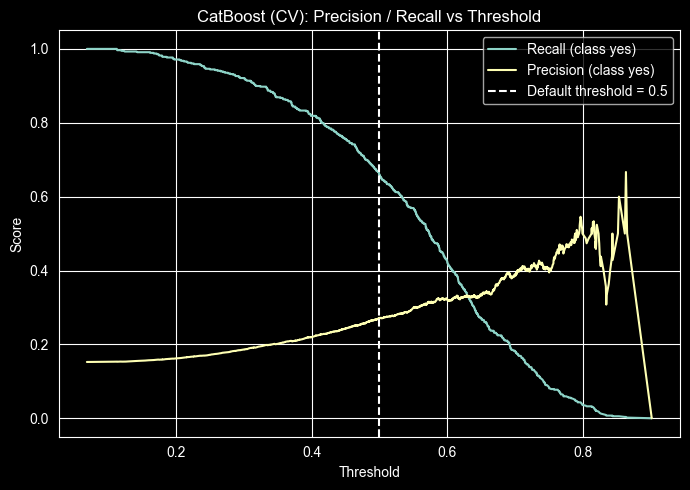

Best threshold (CV, CatBoost): 0.500
Best F1-score (CV): 0.384


In [17]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(
    y,
    oof,
    pos_label='yes'
)

plt.figure(figsize=(7, 5))
plt.plot(thresholds, recall[:-1], label='Recall (class yes)')
plt.plot(thresholds, precision[:-1], label='Precision (class yes)')

plt.axvline(0.5, linestyle='--', label='Default threshold = 0.5')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('CatBoost (CV): Precision / Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


thresholds_grid = np.linspace(0.01, 0.5, 200)

best_threshold = None
best_f1 = 0

for t in thresholds_grid:
    y_pred_t = (oof >= t).astype(int)
    f1 = f1_score(
        (y == 'yes').astype(int),
        y_pred_t,
        zero_division=0
    )

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Best threshold (CV, CatBoost): {best_threshold:.3f}")
print(f"Best F1-score (CV): {best_f1:.3f}")

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

y_true_bin = (y == 'yes').astype(int)
y_pred_opt = (oof >= best_threshold).astype(int)

print(f"Classification Report (CatBoost | threshold = {best_threshold})")
print(classification_report(y_true_bin, y_pred_opt))
print("Confusion matrix:")
print(confusion_matrix(y_true_bin, y_pred_opt))

Classification Report (CatBoost | threshold = 0.5)
              precision    recall  f1-score   support

           0       0.92      0.68      0.78      3099
           1       0.27      0.66      0.38       557

    accuracy                           0.68      3656
   macro avg       0.59      0.67      0.58      3656
weighted avg       0.82      0.68      0.72      3656

Confusion matrix:
[[2112  987]
 [ 190  367]]
